# Chinese-English Frame Alignment

Using naive set comparisons and Jaccard indexing, outputs data to chin_to_eng_best.txt (most aligned eng frame for each chinese -- naive), eng_to_chin_best_sortENG.txt (most aligned chin frame for each eng, sorted by eng -- naive),  eng_to_chin_best_sortCHIN.txt (most aligned chin frame for each eng, sorted by eng -- naive), and jac_chin_to_eng_best.txt (most aligned english frame for each chin -- Jaccard)

# TODO

- bilingual dictionary
- tips？Google translate 
- nlp word form tips I should be aware of.
- Use word vectors instead?
    - multi-lingual wordnet (http://compling.hss.ntu.edu.sg/omw/)
- Read about stanford dependency parser: https://nlp.stanford.edu/software/lex-parser.shtml
- Generalize Frame classes between languages?
- Which direction should I translate from and to?
- Control f all TODOS
----------------------------------------------------------------------------------------------------
4/18/19
- Make the graph show the chinese frame, edge weight
    - https://jdhao.github.io/2017/05/13/guide-on-how-to-use-chinese-with-matplotlib/
- Try other set similarity measures
    - Weighting, Jaccard
- Multilingual FrameNet
    - See if it gives different results than bilingual dictionary
    - .6f1
- Ask about if we want duplicates

----------------------------------------------------------------------------------------------------
4/25/19
- Worked on
    - Debugged simple alignment
    - Graph weights
    - Got Jaccard
    - Starting on WordNet
    - Chinese font... Even Times is not found as a font
- Todo:
    - Chinese font
    - Compare 
    - POS tagging errors (early in pielining)
- Questions
    - Why is "来到“ an LU by itself, isn't it two words?

In [144]:
import xml.etree.ElementTree as ET
import os
import json

# Object Creation


In [145]:
data_dir_str = "data/"
chin_frame_dir_str = "chin/"
eng_frame_dir_str = "bfn/"

In [146]:
class Frame_CHIN:
    def __init__(self, ID, name, name_en, dfn="---"):
        self.ID = ID
        self.name = name # TODO: changeto be named lex_name
        self.name_en = name_en
        self.dfn = dfn # no definition of frame
        
        self.lus = []
    
    def __str__(self):
        return str(self.ID) + ", " + self.name + ", (" + self.name_en + "): "# + str(self.lus[0]) + ". " # TODO: LUs

class Frame_EN:
    def __init__(self, ID, name, dfn):
        self.ID = ID
        self.name = name
        self.dfn = dfn
        
        self.lus = []
        
    def __str__(self):
        return self.name + ": " + self.dfn + ": " + (str(self.lus[0]) if len(self.lus) > 0 else "") + ".\n"

# shared between all langauges
class LU:
    def __init__(self, ID, name, pos, lex_name="---", dfn="---"):
        self.ID = ID
        self.name = name
        self.pos = pos
        
        self.lex_name = lex_name # TODO: what's this
        self.dfn = dfn
        
    def __str__(self):
        return self.name

In [147]:
chin_frames = []
eng_frames = []

chin_id_to_frame = {}
eng_id_to_frame = {}

# To help find the number of frames in each language
eng_max_ID = 0
chin_max_ID = 0

In [148]:
# Parse a Chinese Frame from the XML data
def parse_chin_frame(file_name):
    global chin_max_ID
    
    tree = ET.parse(file_name)
    root = tree.getroot()

    fc = Frame_CHIN(int(root.get("id")), root.get("name"), root.get("name_en"))
    chin_max_ID = max(chin_max_ID, int(root.get("id")))
    for lu_elem in root.findall("LexicalUnit"):
        lu = LU(lu_elem.get("id"), lu_elem.get("name"), lu_elem.get("POS_MARK"))
        fc.lus.append(lu)
    
    chin_frames.append(fc)
    
    
# TODO: figure out which words don't have a certain element, although this shouldn't happen
    
def parse_eng_frame(file_name):
    global eng_max_ID
    
    tree = ET.parse(file_name)
    root = tree.getroot()
    f_eng = Frame_EN(int(root.get("ID")), root.get("name"), root.find("{http://framenet.icsi.berkeley.edu}definition").text)
    eng_max_ID = max(eng_max_ID, int(root.get("ID")))
    
    for lu_elem in root.findall("{http://framenet.icsi.berkeley.edu}lexUnit"):
        lexeme_elem = lu_elem.find("{http://framenet.icsi.berkeley.edu}lexeme")
        lu = LU(lu_elem.get("ID"), lu_elem.get("name"), lu_elem.get("POS"), lexeme_elem.get("name"), lu_elem.find("{http://framenet.icsi.berkeley.edu}definition").text)
        f_eng.lus.append(lu)
        
    eng_frames.append(f_eng)


In [149]:
# Read FrameNet Files

chin_dir = os.fsencode(data_dir_str + chin_frame_dir_str)
eng_dir = os.fsencode(data_dir_str + eng_frame_dir_str)

for file in os.listdir(chin_dir):
     file_name = os.fsdecode(file)
     if file_name.endswith(".xml"):
        parse_chin_frame(os.path.join(chin_dir.decode(), file_name))

print(chin_frames[0])


for file in os.listdir(eng_dir):
     file_name = os.fsdecode(file)
     if file_name.endswith(".xml"):
        parse_eng_frame(os.path.join(eng_dir.decode(), file_name))

print(eng_frames[1])

28, 知觉特征, (perception_description_holistic): 
Attitude_description: <def-root>The lexical units in this frame are descriptions of a <fen>Cognizer</fen>'s <fen>Attitude</fen> about or outlook on a <fen>State_of_affairs</fen>.   

<ex></ex>
<ex><fex name="Cog">Carl</fex> is becoming <fex name="Deg">more</fex> <t>pessimistic</t> <fex name="State">about the negotiations</fex> every day.</ex>

<ex>The benefits of cluelessness come from living in a society where <fex name="Cog">people</fex> <m>take</m> an <t>optimistic</t> <fex name="Att">view</fex> <fex name="State">of life</fex>.</ex>
<ex></ex>
The <fen>State_of_affairs</fen> can be expressed without a <fen>Cognizer</fen> in many cases, as shown in the following:
<ex></ex>
<ex><fex name="State">The situation</fex> is <fex name="Deg">fairly</fex> <t>grim</t> at the moment.</ex>
<ex></ex>

</def-root>: optimistic.a.



In [150]:
# Generate mapping from ID to Frame object

for chin_frame in chin_frames:
    chin_id_to_frame[chin_frame.ID] = chin_frame
for eng_frame in eng_frames:
    eng_id_to_frame[eng_frame.ID] = eng_frame
    

![Image](img/board.jpg)
![Image](img/board2.jpg)

# Alignment

Create lookup tables, mapping from lexeme to frame (Chinese and English)

In [151]:
print(len(chin_frames), len(eng_frames))

323 1221


In [152]:
print("NON-UNIQUE")
print("Num of English LUs: " + str(sum([len(eng_frames[i].lus) for i in range(len(eng_frames))])))
print("Num of Chinese LUs: " + str(sum([len(eng_frames[i].lus) for i in range(len(chin_frames))])))
# s = 10
# len(eng_frames[s].lus)

NON-UNIQUE
Num of English LUs: 13631
Num of Chinese LUs: 3522


Unused: counting each wordform of LU only once even if it appears multiple times

In [153]:
# # Sample use: eng_lemma_to_frame{'optimistic'} = [<__main__.Frame_EN object at 0x110507f60>], 'pessimistic': [<__main__.Frame_EN object at 0x110507f60>], ...]
# # Used to speed up finding which English frames has LU's that Chinese LU's translate into

# eng_lemma_to_frame = {} # Only need eng dict for now because we want to optimize looking up which English frames have a given LU (that is translated from Chinese)
#                         # eng_lemma_to_frame[LU]: maps LU to its list of frame objects 
#                         # TODO: use ID's instead

# # Go through each English frame and map every LU to all the frames that that LU is a part of
# # Note: something I fixed if the same LU, ie. "in" is listed multiple times as an LU for a certain frame (ie. Conditional_occurrence) it will be counted multiple times!
# for eng_frame in eng_frames:
# #     print(eng_frame.name)
#     for lu in eng_frame.lus:
#         if lu.lex_name in eng_lemma_to_frame:
#             if eng_frame not in eng_lemma_to_frame[lu.lex_name]: # Only add this frame if we haven't connected this lu to eng_frame yet
#                 eng_lemma_to_frame[lu.lex_name].append(eng_frame) #.append(eng_frame.name)
# #                 if lu.lex_name == "in": 
# #                     print(lu.lex_name, eng_frame.name)
#         else:
#             eng_lemma_to_frame[lu.lex_name] = [eng_frame] #[eng_frame]
            
# # print(eng_lemma_to_frame)
# avg = sum([len(frame_list) for frame_list in eng_lemma_to_frame.values()]) / len(eng_lemma_to_frame.values())
# print("Average number of English frames each lemma is an LU of: " + str(avg))
# print(len(eng_lemma_to_frame.values()) * avg) # sanity check. Should equal the above quantity "Num of English LUs: 13631"

In [154]:
# # Output all frames that are associated with each "lemma"

# [(lemma, [frame.name for frame in eng_lemma_to_frame[lemma]]) for lemma in eng_lemma_to_frame.keys()]

This one counts double counts duplicates of a certain LU lex name for one frame, which is what we want for Jaccard and in in general

In [155]:
# eng_lemma_to_frame{'optimistic'} = [<__main__.Frame_EN object at 0x110507f60>], 'pessimistic': [<__main__.Frame_EN object at 0x110507f60>], ...]
# Used to speed up finding which English frames has LU's that Chinese LU's translate into

eng_lemma_to_frame = {} # Only need eng dict for now because we want to optimize looking up which English frames have a given LU (that is translated from Chinese)
                        # eng_lemma_to_frame[LU]: maps LU to its list of frame objects 
                        # TODO: use ID's instead

# Go through each English frame and map every LU to all the frames that that LU is a part of
# Note: if the same LU, ie. "in" is listed multiple times as an LU for a certain frame (ie. Conditional_occurrence) it will be counted multiple times!
for eng_frame in eng_frames:
#     print(eng_frame.name)
    for lu in eng_frame.lus:
        if lu.lex_name in eng_lemma_to_frame:
#             if eng_frame not in eng_lemma_to_frame[lu.lex_name]: # Only add this frame if we haven't connected this lu to eng_frame yet
            eng_lemma_to_frame[lu.lex_name].append(eng_frame) #.append(eng_frame.name)
#                 if lu.lex_name == "in": 
#                     print(lu.lex_name, eng_frame.name)
        else:
            eng_lemma_to_frame[lu.lex_name] = [eng_frame] #[eng_frame]
            
# print(eng_lemma_to_frame)
avg = sum([len(frame_list) for frame_list in eng_lemma_to_frame.values()]) / len(eng_lemma_to_frame.values())
print("Average number of English frames each lemma is an LU of: " + str(avg))
print(len(eng_lemma_to_frame.values()) * avg) # sanity check. Should equal the above quantity "Num of English LUs: 13631"

Average number of English frames each lemma is an LU of: 1.5877693651718112
13631.0


## Azure Lookup

Unused for now -- free trial ran dry and a local backup of definitions is good enough

In [156]:
# import os, requests, uuid, json

In [157]:
# subscriptionKey = '6682a99b673847baaf34f2f0f4591cf4'

In [158]:
# base_url = 'https://api.cognitive.microsofttranslator.com'
# path = '/dictionary/lookup?api-version=3.0'
# params = '&from=zh-Hans&to=en';
# constructed_url = base_url + path + params

# headers = {
#     'Ocp-Apim-Subscription-Key': subscriptionKey,
#     'Content-type': 'application/json',
#     'X-ClientTraceId': str(uuid.uuid4())
# }

### Get！

In [159]:
# # input_words: list words to be translated
# # returns: for each input word, a list of possible translations
# def get_dict_trans_chin_eng(input_words):
#     word_idx = 0
#     trans_words = []
    
#     while word_idx < len(input_words): # translate 10 words at a time due to API limit
#         curr_words = input_words[word_idx: min(word_idx+10, len(input_words))]
# #         print("Currwords: " + str(curr_words))
#         req_body = [{"Text": word} for word in curr_words]
#         request = requests.post(constructed_url, headers=headers, json=req_body)
#         response = request.json()

# #         print(response)

#         for word in response:
#             # ignore confidence and POS for now
#             # TODO: limit to N=10 
#             # TODO: what to do about spaces?
#             # TODO: use more than just the returned words
#             if "translations" not in word or word is None or word["translations"] is None:
#                 trans_words.append([])
#                 continue
#             curr_word_translations = [trans["normalizedTarget"] for trans in word["translations"]]
#             trans_words.append(curr_word_translations)
        
#         word_idx += 10
#     return trans_words

In [160]:
# get_dict_trans_chin_eng(["是"])

Go through all Chinese frames and their LU's, and translate them into English. For any English frame with that LU, increase the weight of that connection.

In [161]:
weight = {} # weight[(Chinese frame ID, English frame ID)]: weight of that alignment relationship

### Unoptimized Weighting

In [162]:
# # Uses Azure to retrieve all the transations for the Chinese LU's. Looks through all English frames each time

# cnt = 0

# weizhi_aligns = []

# for chin_frame in chin_frames[100:101]:
#     chin_lemmas = [lu.name for lu in chin_frame.lus]
# #     print(chin_lemmas)
#     trans_lemmas = get_dict_trans_chin_eng(chin_lemmas) # translated lemmas (are in english now)
# #     print(trans_lemmas)

#     for trans_lemma in trans_lemmas: # trans_lemma = list of possible translations of the chinese lemma
#         for possib_trans_lemma in trans_lemma: # possib_trans_lemma = actual word
#             for eng_frame in eng_frames: # look through all English frames
#                 eng_lemmas = [lu.lex_name for lu in eng_frame.lus] # the lemmas in the english Frame itself
#                 if possib_trans_lemma in eng_lemmas: # if one of our possible translations
# #                     print(possib_trans_lemma + ": Aligned " + chin_frame.name + " with " + eng_frame.name)
#                     cnt += 1
#                     weizhi_aligns.append(eng_frame.name)
# #                     pass
# print (cnt)
# # chin_frames
# #                     print("checking '" + possib_trans_lemma + "' against " + str(eng_lemmas))
# #                     print("YEET")
# #                     print("Aligned " + chin_frame.name + " with " + eng_frame.name)

In [163]:
# weizhi_aligns.sort()
# weizhi_aligns

### Optimized Weighting

In [164]:
# trans_chin_to_eng_cache = {} # Sample dictionary use: trans_chin_to_eng_cache['亮'] = ['bright', 'lighter', 'liang', 'shines', 'shiny', 'brightness']

In [165]:
# What am I doing here?

# for chin_frame in chin_frames[100:101]:
#     chin_lemmas = [lu.name for lu in chin_frame.lus]
# #     print(chin_lemmas)
#     trans_lemmas = get_dict_trans_chin_eng(chin_lemmas) # translated lemmas (are in english now)
#     print(trans_lemmas)
#     print(len(chin_lemmas), len(trans_lemmas))
    
    
# #     for c_i in range(len(chin_lemmas)):
# #         cl = chin_lemmas[c_i]
# #         trans_chin_to_eng_cache[cl] = trans_lemmas[c_i] # cache english translations


### Local translation optimized

No more need for Azure translation after caching the translations:

In [166]:
trans_chin_to_eng_cache = {} # Sample dictionary use: trans_chin_to_eng_cache['亮'] = ['bright', 'lighter', 'liang', 'shines', 'shiny', 'brightness']

In [167]:
### Dump translations into json file: only need to do once

# with open('chin_to_eng_word_dict.json', 'w') as fp:
#     json.dump(trans_chin_to_eng_cache, fp, ensure_ascii=False)

In [168]:
# Load Chinese to English translations from json cache file

with open('chin_to_eng_word_dict.json') as json_file:  
    trans_chin_to_eng_cache = json.load(json_file)

In [169]:
# Sample array use: weights_table[c_idx][e_idx] = "weight"
weights_table = [[0 for e in range(eng_max_ID)] for c in range(chin_max_ID)]

len(weights_table), len(weights_table[0]) # number of chinese frames, number of English frames

(323, 3020)

In [170]:
# Look at the side comments in this loop to help understand what is going on
for chin_frame in chin_frames:
    chin_lemmas = [lu.name for lu in chin_frame.lus] # List of Chinese LU's for this frame
#     print(chin_lemmas)
    trans_lemmas = [trans_chin_to_eng_cache[chin_lemma] for chin_lemma in chin_lemmas] # trans_lemmas[1][3] = 4th translation of the 2nd chinese LU of this frame 
#  print(trans_lemmas)
    # TODO: distinct LUs in Chinese map to the same LU in English?
    for trans_lemma_lst in trans_lemmas: # trans_lemma_lst[0] = first possible translation for this LU
        for possib_trans_lemma in trans_lemma_lst: # possib_trans_lemma = this translated version of the LU
            if possib_trans_lemma in eng_lemma_to_frame: # If this translated version of the LU is an LU for any English frame
#                 print("\n", possib_trans_lemma, "is in", [e.name for e in eng_lemma_to_frame[possib_trans_lemma]], "\n")
                for eng_frame in eng_lemma_to_frame[possib_trans_lemma]:
                    # Update weights in the table and the dictionary (TODO: more graceful way of keeping track)
                    # TODO: merge these two to be graceful
                    weights_table[chin_frame.ID][eng_frame.ID] += 1
                    if (chin_frame, eng_frame) not in weight:
                        weight[(chin_frame, eng_frame)] = 1
                    else:
                        weight[(chin_frame, eng_frame)] += 1

[[], [], [], ['bright', 'lighter', 'liang', 'shines', 'shiny', 'brightness'], ['bright', 'brightly', 'luminous', 'brightness', 'brilliant'], ['ming', 'bright', 'prescribed'], ['brightened', 'bright'], [], ['discerning', 'sharp', 'wide open'], ['bright', 'brightly colored'], [], ['translucent'], ['clear', 'brighter'], [], [], ['brilliant', 'brilliance', 'glorious', 'splendor', 'glory', 'splendid', 'magnificently', 'resplendence', 'magnificence', 'magnificent'], ['sprightly', 'crisp', 'crisper', 'bright', 'lively'], [], ['golden'], [], [], [], ['dazzling'], ['dazzling', 'dazzlingly', 'dazzle', 'glaring', 'bright', 'shining', 'glare', 'shiny'], ['dazzling', 'blinding', 'glare', 'glaring'], [], ['glare', 'dazzling', 'glaring', 'harsh', 'blinding'], ['splendid', 'brilliant', 'bright', 'shining', 'glitter', 'glorious', 'brightly'], [], ['jiaojiao'], ['bright'], ['dark', 'dim', 'dull', 'concealed', 'hidden', 'darkness'], ['shadowy', 'dark', 'shady', 'murky', 'gloomy', 'somber', 'gloom', 'dark

in is in ['Biological_urge', 'Domain', 'Hedging', 'Compliance', 'Wearing', 'Degree', 'Fields', 'Taking_time', 'Conditional_occurrence', 'Conditional_occurrence', 'Commonality', 'Destiny', 'Taking_sides', 'Being_operational', 'Proportional_quantity', 'Proportional_quantity', 'Contrary_circumstances', 'Contrary_circumstances', 'Text_creation', 'Accompaniment', 'Amounting_to', 'Presentation_of_mitigation', 'Presentation_of_mitigation', 'Expected_location_of_person', 'Medium', 'Non-gradable_proximity', 'Non-gradable_proximity', 'Frequency', 'Desiring', 'Desiring', 'Purpose', 'Relative_time', 'Contacting', 'Temporal_collocation', 'Time_vector', 'Popularity', 'Popularity', 'Collaboration', 'Collaboration', 'Concessive', 'Interior_profile_relation', 'Interior_profile_relation', 'Interior_profile_relation'] 

## Output

In [171]:
import numpy as np

### Most closely aligned English frame (naive)

In [172]:
# TODO: gaps in English frame IDs

f = open("chin_to_eng_best.txt","w+")

num_aligned = 0 # TODO: change name

for chin_ID in range(1, len(weights_table)):
#     print(max(weights_table[chin_ID]))
    chin_array = np.array(weights_table[chin_ID])
    best_english_frame_ID = np.argmax(chin_array)
    if best_english_frame_ID == 0:
        s = "(" + str(chin_ID) + ") No match found for " + chin_id_to_frame[chin_ID].name
        print(s)
        f.write(s + "\n")
    else:
        s = "(" + str(chin_ID) + ") " + chin_id_to_frame[chin_ID].name + " ~= (" + str(best_english_frame_ID) + ") " + eng_id_to_frame[best_english_frame_ID].name
        print(s)
        f.write(s + "\n")
        num_aligned += 1
    
    
#     print(chin_ID, chin_id_to_frame[chin_ID])

f.close()
    

(1) 辨别 ~= (24) Differentiation
(2) 获知 ~= (19) Awareness
(3) 陈述  ~= (43) Statement
(4) 逮捕 ~= (17) Manipulation
(5) 盗窃 ~= (94) Theft
(6) 发声 ~= (69) Make_noise
(7) 发现  ~= (20) Becoming_aware
(8) 范畴化 ~= (1594) Continued_state_of_affairs
(9) 非自主感知 ~= (70) Perception_experience
(10) 感受 ~= (71) Sensation
(11) No match found for 感知觉
(12) 观点 ~= (1412) Opinion
(13) 记忆 ~= (1222) Remembering_experience
(14) 经历变化 ~= (1172) Undergo_change
(15) 量变 ~= (91) Change_position_on_a_scale
(16) 偏向性 ~= (349) Partiality
(17) 破坏 ~= (417) Destroying
(18) 情景记忆 ~= (1222) Remembering_experience
(19) 身体感知 ~= (68) Perception_body
(20) 使变化 ~= (683) Cause_change
(21) 推理 ~= (23) Coming_to_believe
(22) 位移 ~= (7) Motion
(23) 鲜明性 ~= (1360) Obviousness
(24) 信息交流 ~= (6) Communication
(25) 行动记忆 ~= (1222) Remembering_experience
(26) 运送 ~= (240) Bringing
(27) 诈骗 ~= (92) Manipulate_into_doing
(28) 知觉特征 ~= (2712) Level_of_light
(29) 自主感知 ~= (66) Perception_active
(30) 包含 ~= (375) Difficulty
(31) 保密状态 ~= (1145) Secrecy_status
(32)

In [173]:
num_aligned

269

### Most closely aligned Chinese frame (naive)

As desired, output is sorted in both english and Chinese frame ID order in separate files

In [174]:
inverted = np.array(weights_table)
sort_by_chinese = [] # Best aligned Chinese frame to each English frame, sorted by Chinese ID

inverted = inverted.transpose()

f_sort_eng = open("eng_to_chin_best_sortENG.txt","w+")

num_aligned = 0

for eng_ID in range(1, len(inverted)):
#     print(max(weights_table[chin_ID]))
    if eng_ID not in eng_id_to_frame:
        continue
        
    eng_array = np.array(inverted[eng_ID])
    best_chinese_frame_ID = np.argmax(eng_array)
    if best_chinese_frame_ID == 0:
        s = "(" + str(eng_ID) + ") No match found for " + eng_id_to_frame[eng_ID].name
        f_sort_eng.write(s + "\n")
#         print(s)
    else:
#         if best_chinese_frame_ID not in chin_id_to_frame:
#             print("No chinese framefound??", best_chinese_frame_ID, np.argmax(eng_array), len(eng_array))
        s = "(" + str(eng_ID) + ") " + eng_id_to_frame[eng_ID].name + " ~= (" + str(best_chinese_frame_ID) + ") " + chin_id_to_frame[best_chinese_frame_ID].name
        f_sort_eng.write(s + "\n")
#         print(s)
        num_aligned += 1
        
        sort_by_chinese.append((eng_ID, best_chinese_frame_ID))
    
f_sort_eng.close()






f_sort_chin = open("eng_to_chin_best_sortCHIN.txt","w+")
#     print(chin_ID, chin_id_to_frame[chin_ID])

sort_by_chinese.sort(key=lambda x: x[1])
# print(sort_by_chinese)


for eng_ID, best_chinese_frame_ID in sort_by_chinese:
    s = "(" + str(eng_ID) + ") " + eng_id_to_frame[eng_ID].name + " ~= (" + str(best_chinese_frame_ID) + ") " + chin_id_to_frame[best_chinese_frame_ID].name
    f_sort_chin.write(s + "\n")
    print(s)

f_sort_chin.close() 


(24) Differentiation ~= (1) 辨别
(218) Cardinal_numbers ~= (1) 辨别
(793) Being_born ~= (1) 辨别
(2247) Non-commutative_statement ~= (1) 辨别
(2980) Transition_to_a_situation ~= (1) 辨别
(6) Communication ~= (3) 陈述 
(32) Candidness ~= (3) 陈述 
(34) Discussion ~= (3) 陈述 
(41) Request ~= (3) 陈述 
(43) Statement ~= (3) 陈述 
(44) Volubility ~= (3) 陈述 
(255) Medical_professionals ~= (3) 陈述 
(256) Medical_specialties ~= (3) 陈述 
(285) Silencing ~= (3) 陈述 
(483) Reporting ~= (3) 陈述 
(523) Speak_on_topic ~= (3) 陈述 
(550) Claim_ownership ~= (3) 陈述 
(750) Telling ~= (3) 陈述 
(796) Communicate_categorization ~= (3) 陈述 
(920) Cause_fluidic_motion ~= (3) 陈述 
(1025) Connecting_architecture ~= (3) 陈述 
(1146) Reveal_secret ~= (3) 陈述 
(1154) Unattributed_information ~= (3) 陈述 
(1462) Explaining_the_facts ~= (3) 陈述 
(1620) Institutionalization ~= (3) 陈述 
(1621) Complaining ~= (3) 陈述 
(1624) Bragging ~= (3) 陈述 
(2974) Affirm_or_deny ~= (3) 陈述 
(94) Theft ~= (5) 盗窃
(39) Communication_noise ~= (6) 发声
(60) Motion_noise ~=

In [175]:
num_aligned

950

### Top closely aligned frames (naive)

In [176]:
weights_as_list = [((key[0].ID, key[0].name), (key[1].ID, key[1].name), weight[key]) for key in weight.keys()]
weights_as_list.sort(key=lambda l: -l[2])
weights_as_list

[((230, '心理刺激'), (46, 'Emotion_directed'), 203),
 ((253, '杀害'), (590, 'Killing'), 143),
 ((76, '情感体验'), (48, 'Experiencer_focus'), 110),
 ((230, '心理刺激'), (47, 'Experiencer_obj'), 94),
 ((3, '陈述 '), (43, 'Statement'), 88),
 ((295, '文本'), (298, 'Text'), 80),
 ((230, '心理刺激'), (48, 'Experiencer_focus'), 78),
 ((76, '情感体验'), (46, 'Emotion_directed'), 75),
 ((10, '感受'), (71, 'Sensation'), 62),
 ((219, '情感反应'), (46, 'Emotion_directed'), 57),
 ((64, '渴望'), (366, 'Desiring'), 55),
 ((41, '发光'), (105, 'Location_of_light'), 55),
 ((210, '依从'), (117, 'Compliance'), 52),
 ((116, '因果'), (5, 'Causation'), 51),
 ((230, '心理刺激'), (364, 'Stimulus_focus'), 47),
 ((189, '体型特征'), (157, 'Body_description_holistic'), 45),
 ((118, '证明'), (25, 'Evidence'), 45),
 ((250, '传达评价'), (219, 'Judgment_communication'), 45),
 ((29, '自主感知'), (66, 'Perception_active'), 45),
 ((16, '偏向性'), (349, 'Partiality'), 44),
 ((23, '鲜明性'), (1360, 'Obviousness'), 43),
 ((67, '类似'), (481, 'Similarity'), 42),
 ((88, '思考'), (22, 'Cogitat

In [177]:
eng_max_ID, chin_max_ID

# TODO: 1 based index

(3020, 323)

### Graph (naive)

Basic graph showing most closely aligned frames to 心理刺激, visualized with differing edge weights

In [178]:
import matplotlib.font_manager as mfm
import matplotlib.pyplot as plt
import matplotlib as mp

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as matplotlib


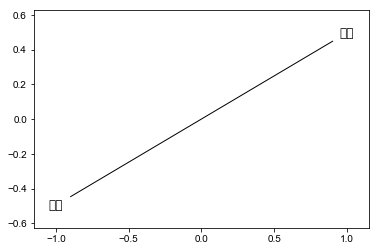

In [179]:
g = nx.Graph()

g.add_edge('挪威', '瑞典')
nx.draw_networkx(g, font_family='DejaVu Sans', node_size=1000,
    node_color='white')
plt.savefig('plot.png')

English frame, edge weight
Emotion_directed,  1.0
Experiencer_obj,  0.4630541871921182
Experiencer_focus,  0.3842364532019704
Medical_conditions,  0.04926108374384237
Stimulus_focus,  0.2315270935960591
Biological_urge,  0.059113300492610835
Emotions_of_mental_activity,  0.08866995073891626
Just_found_out,  0.09852216748768473
Fear,  0.1625615763546798


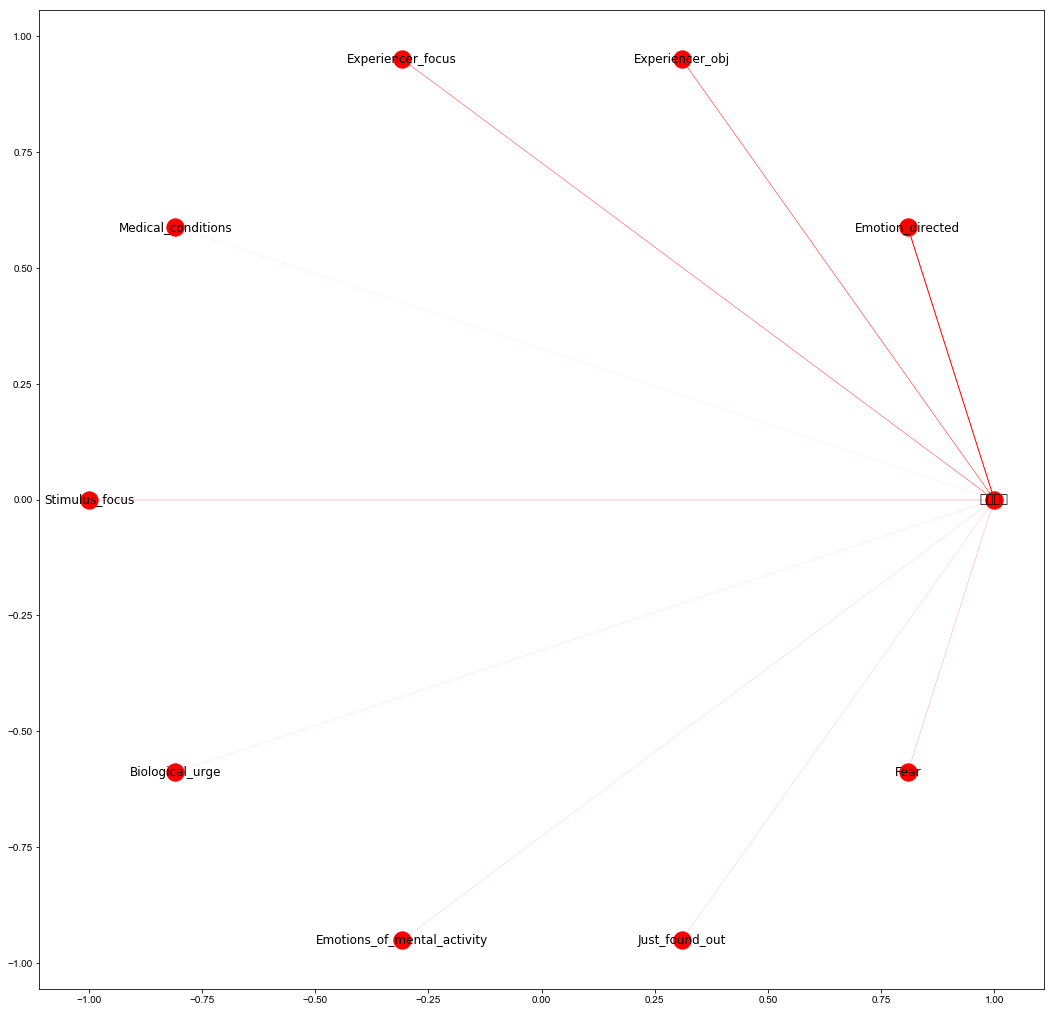

In [180]:
G = nx.Graph()

# for chin_ID in range(1, len(weights_table)):
chin_ID = 230 # for 心理刺激
chin_array = np.array(weights_table[chin_ID])

print("English frame, edge weight")
for eng_ID in range(len(chin_array)): # Find all the English frames that have more than 10 LU matches to 心理刺激
    if chin_array[eng_ID] < 10:
        continue
    if eng_ID in eng_id_to_frame:
        print(eng_id_to_frame[eng_ID].name + ", ", chin_array[eng_ID] / 203)
        G.add_edge(chin_id_to_frame[chin_ID].name, eng_id_to_frame[eng_ID].name, font_family='SimHei', color='r', weight=chin_array[eng_ID]/203)
        
# best_english_frame_ID = np.argmax(chin_array)
#     if best_english_frame_ID == 0:
#         print(str(chin_ID) + " No match found for " + chin_id_to_frame[chin_ID].name)
#     else:
#         print(str(chin_ID) + " " + chin_id_to_frame[chin_ID].name + " is best aligned with " + eng_id_to_frame[best_english_frame_ID].name)
    
#     print(chin_ID, chin_id_to_frame[chin_ID])

# G.add_edge(1,2,color='r',weight=2)
# G.add_edge(2,3,color='b',weight=4)
# G.add_edge(3,4,color='g',weight=6)

pos = nx.circular_layout(G)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

# nx.draw_networkx(G)
matplotlib.rc('font', family='Arial')
plt.figure(figsize=(18,18))
nx.draw_networkx(G, pos, edges=edges, edge_color=colors, width=weights)
plt.show()

TODO: font help from https://jdhao.github.io/2017/05/13/guide-on-how-to-use-chinese-with-matplotlib/

## Jaccard Comparisons

In [181]:
# Sample use: jac_weight[(chinese frame, english frame)] = jaccard index between the two frames
# Sample use: jac_weights_table[c_idx][e_idx] = jaccard index between the two frames
jac_weight = {}
jac_weights_table = [[0 for e in range(eng_max_ID)] for c in range(chin_max_ID)]

len(weights_table), len(weights_table[0]) # number of chinese frames, number of English frames

(323, 3020)

In [182]:
# new_cnt = 0
weizhi_aligns2 = []
for chin_frame in chin_frames:
#     print(chin_frame.name)
    chin_lemmas = [lu.name for lu in chin_frame.lus] # List of Chinese LU's for this frame
#     print(chin_lemmas)
    trans_lemmas = [trans_chin_to_eng_cache[chin_lemma] for chin_lemma in chin_lemmas] # trans_lemmas[1][3] = 4th translation of the 2nd chinese LU of this frame 
#     print(trans_lemmas)
    
    # TODO: distinct LUs in Chinese map to the same LU in English?
    
    # Note: Jaccard forces merging of having multiple Chinese LU's translate to the same English word (eg. 来到，到达 --> 'arrival')
    merged_trans_lemmas = set() # merged_trans_lemmas is this merged set
    for trans_lemma_lst in trans_lemmas:
        for possib_trans_lemma in trans_lemma_lst:
            merged_trans_lemmas.add(possib_trans_lemma)

    # Changed loop from above to incorporate merging of translated LU's
    for possib_trans_lemma in merged_trans_lemmas:
        if possib_trans_lemma in eng_lemma_to_frame: # If this translated version of the LU is an LU for any English frame
#                 print("\n", possib_trans_lemma, "is in", [e.name for e in eng_lemma_to_frame[possib_trans_lemma]], "\n")
            for eng_frame in eng_lemma_to_frame[possib_trans_lemma]:
#                     print(possib_trans_lemma + ": Aligned " + chin_frame.name + " with " + eng_frame.name)
                weizhi_aligns2.append(eng_frame.name)
                jac_weights_table[chin_frame.ID][eng_frame.ID] += 1
                if (chin_frame, eng_frame) not in jac_weight:
                    jac_weight[(chin_frame, eng_frame)] = 1
                else:
                    jac_weight[(chin_frame, eng_frame)] += 1

# Jaccard denominator
for chin_ID in range(1, len(jac_weights_table)):
    for eng_ID in range(len(jac_weights_table)):
        if eng_ID not in eng_id_to_frame: # Can't assume that the english ID's don't skip certain ID numbers
            continue
        chin_frame = chin_id_to_frame[chin_ID]
        eng_frame = eng_id_to_frame[eng_ID]
        
        # Jaccard special case
        if len(chin_frame.lus) == 0 and len(eng_frame.lus) == 0:
            jac_weights_table[chin_frame.ID][eng_frame.ID] = 1
            
        denom = len(chin_frame.lus) + len(eng_frame.lus) - (jac_weights_table[chin_frame.ID][eng_frame.ID])
        if denom == 0:
            print(chin_ID, chin_id_to_frame[chin_ID].name, len(chin_frame.lus), len(eng_frame.lus), jac_weights_table[chin_frame.ID][eng_frame.ID])
        jac_weights_table[chin_frame.ID][eng_frame.ID] = jac_weights_table[chin_frame.ID][eng_frame.ID] / denom

In [183]:
# TODO: gaps in English frame IDs

f = open("jac_chin_to_eng_best.txt","w+")

num_aligned = 0 # TODO: change name

for jac_chin_ID in range(1, len(jac_weights_table)):
    jac_chin_array = np.array(jac_weights_table[jac_chin_ID])
    jac_best_eng_ID = np.argmax(jac_chin_array)
    
    if jac_best_eng_ID == 0:
        s = "(" + str(jac_chin_ID) + ") No match found for " + chin_id_to_frame[jac_chin_ID].name
        print(s)
        f.write(s + "\n")
    else:
        s = "(" + str(jac_chin_ID) + ") " + chin_id_to_frame[jac_chin_ID].name + " ~= (" + str(eng_id_to_frame[jac_best_eng_ID].ID) + ") " + eng_id_to_frame[jac_best_eng_ID].name

        print(s)
        f.write(s + "\n")
        num_aligned += 1
    
    
#     print(chin_ID, chin_id_to_frame[chin_ID])
f.close()
    

(1) 辨别 ~= (481) Similarity
(2) 获知 ~= (1681) Being_awake
(3) 陈述  ~= (1146) Reveal_secret
(4) 逮捕 ~= (979) Grasp
(5) 盗窃 ~= (432) Offenses
(6) 发声 ~= (850) Sounds
(7) 发现  ~= (403) Achieving_first
(8) 范畴化 ~= (2252) Exemplar
(9) 非自主感知 ~= (1412) Opinion
(10) 感受 ~= (396) Feeling
(11) No match found for 感知觉
(12) 观点 ~= (1412) Opinion
(13) 记忆 ~= (1222) Remembering_experience
(14) 经历变化 ~= (683) Cause_change
(15) 量变 ~= (362) Motion_directional
(16) 偏向性 ~= (349) Partiality
(17) 破坏 ~= (417) Destroying
(18) 情景记忆 ~= (1222) Remembering_experience
(19) 身体感知 ~= (2320) Cause_bodily_experience
(20) 使变化 ~= (683) Cause_change
(21) 推理 ~= (503) Suspicion
(22) 位移 ~= (690) Ride_vehicle
(23) 鲜明性 ~= (1360) Obviousness
(24) 信息交流 ~= (720) Cognitive_connection
(25) 行动记忆 ~= (1222) Remembering_experience
(26) 运送 ~= (386) Ingest_substance
(27) 诈骗 ~= (2570) Intentional_deception
(28) 知觉特征 ~= (354) Desirability
(29) 自主感知 ~= (1400) Regard
(30) 包含 ~= (375) Difficulty
(31) 保密状态 ~= (1145) Secrecy_status
(32) 命名 ~= (1253) Referr

In [184]:
print(num_aligned)

269
